In [1]:
import os 
os.chdir('../../../')
print("Current working directory is now: ", os.getcwd())

import pandas as pd 
import numpy as np
import csv
import utils.interpretable_functions as interpret
import utils.RiskSLIM as slim
import utils.stumps as stumps
import utils.fairness_functions as fairness
from utils.load_settings import load_settings

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import roc_auc_score

from pprint import pprint
from riskslim.helper_functions import load_data_from_csv, print_model

# restore saved variables
%store -r summary_general2_KY_interpret

Current working directory is now:  C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2


C:\Users\binha\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



### CART & EBM

In [2]:
### load data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_data.csv").sort_values('person_id')
data = data.drop(['arnold_fta_raw','arnold_nca_raw','arnold_nvca_raw'], axis=1)
x = data.loc[:,:'current_violence20']
y = data['general_two_year'].values

In [5]:
#### CART
depth = [7,8,9,10]
cart_summary = interpret.CART(X=x,
                         Y=y,
                         depth=depth,
                         seed=816)

#### EBM
estimators = [40]
depth = [2]
learning_rate = [0.7]
ebm_summary = interpret.EBM(X=x,
                       Y=y,
                       learning_rate=learning_rate,
                       depth=depth,
                       estimators=estimators,
                       seed =816)

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:88: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:88: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:88: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:88: RuntimeWarning:

invalid value encountered in longlong_scalars



In [6]:
np.mean(cart_summary['holdout_test_auc']), np.mean(cart_summary['auc_diffs'])

(0.7358934454634021, 0.008078291803447147)

In [7]:
np.mean(ebm_summary['holdout_test_auc']), np.mean(ebm_summary['auc_diffs'])

(0.7419332228253251, 0.002924320379080059)

## Lasso Stumps

 - Notice that controling for the overfitting problem, the more stump features we include, the better prediction results we have. However, we do not want too many features in the model which will violate the definition of interpretability. We control the number of stump features around 30 and the number of original features where the stump features come from to be around 10-12.

In [2]:
## load whole data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_stumps.csv").sort_values('person_id')
original_data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_data.csv").sort_values('person_id')
original_data = original_data.loc[:, ['person_id', 'age_at_current_charge', 'p_charges']]
data = pd.merge(original_data, data, on='person_id')
X_stumps, Y_stumps = data.loc[:,:'current_violence201'], data['general_two_year'].values
Y_stumps[Y_stumps == -1] = 0
cols = X_stumps.columns[5:]

## load train & test data
train_stumps = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_train_stumps.csv")
test_stumps = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_test_stumps.csv")
X_train_stumps, Y_train_stumps = train_stumps.loc[:,:'current_violence201'], train_stumps['general_two_year'].values
X_test_stumps, Y_test_stumps = test_stumps.loc[:,:'current_violence201'], test_stumps['general_two_year'].values
Y_train_stumps[Y_train_stumps == -1] = 0
Y_test_stumps[Y_test_stumps == -1] = 0

#### Nested Cross Validation

In [9]:
stump_summary = stumps.stump_cv(X = X_stumps, 
                                Y = Y_stumps, 
                                columns=cols, 
                                c_grid={'C': [0.001, 0.002, 0.003, 0.004]}, 
                                seed = 816)

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:88: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:88: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:88: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:88: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:88: RuntimeWarning:

invalid value encountered in longlong_scalars



In [10]:
stump_summary['best_params'], np.mean(stump_summary['holdout_test_auc']), np.mean(stump_summary['auc_diffs'])

([{'C': 0.004}, {'C': 0.004}, {'C': 0.004}, {'C': 0.004}, {'C': 0.004}],
 0.7399658211823634,
 0.0003093138235448878)

In [3]:
best_stump_model = stumps.stump_model(X_train_stumps, 
                                      Y_train_stumps, 
                                      X_test_stumps, 
                                      Y_test_stumps, 
                                      c=0.004, 
                                      columns=cols, 
                                      seed=816)
len(best_stump_model['features'])

30

##### Prediction Table

In [12]:
stumps.latex_stump_table(best_stump_model['coefs'], 
                         best_stump_model['features'], 
                         best_stump_model['intercept'], 
                         best_stump_model['dictionary'])

\begin{{tabular}}{{|l|r|r|}} \hline
1. age_at_current_charge19 & 0.014088002320605737 & +... \\ \hline
2. age_at_current_charge20 & 0.07742377152385366 & +... \\ \hline
3. age_at_current_charge21 & 0.03973685415273964 & +... \\ \hline
4. age_at_current_charge24 & 0.01150773133035472 & +... \\ \hline
5. age_at_current_charge27 & 0.03796038492270021 & +... \\ \hline
6. age_at_current_charge30 & 0.010719944023669669 & +... \\ \hline
7. age_at_current_charge35 & 0.06645990987692643 & +... \\ \hline
8. age_at_current_charge39 & 0.1078297223289935 & +... \\ \hline
9. age_at_current_charge47 & 0.12235425694598631 & +... \\ \hline
10. p_arrest2 & 0.6797481107007612 & +... \\ \hline
11. p_arrest3 & 0.42019695050564954 & +... \\ \hline
12. p_arrest4 & 0.2610048760499872 & +... \\ \hline
13. p_arrest5 & 0.1805498783816204 & +... \\ \hline
14. p_arrest6 & 0.1408875119936907 & +... \\ \hline
15. p_arrest7 & 0.204271312045159 & +... \\ \hline
16. p_arrest8 & 0.010834523155030421 & +... \\ \hline
17.

##### Stumps Visualizations

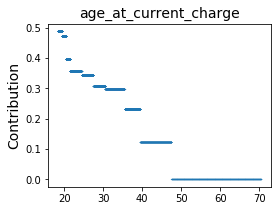

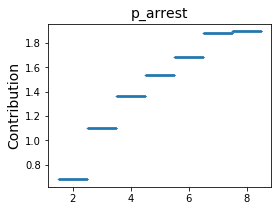

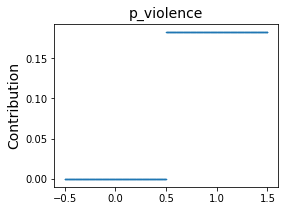

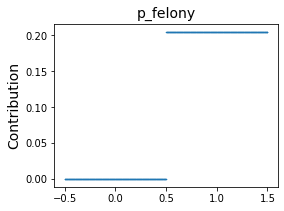

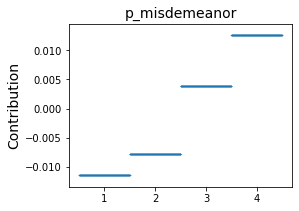

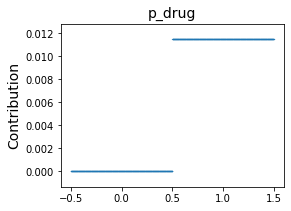

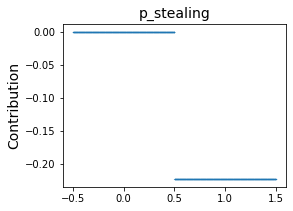

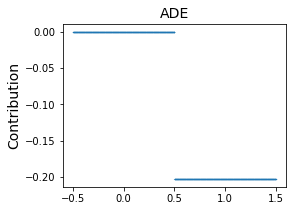

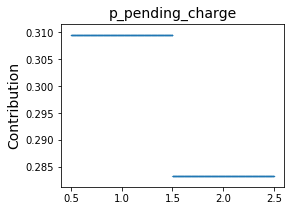

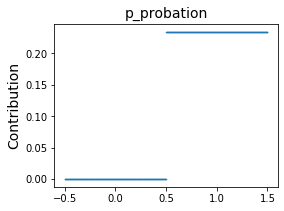

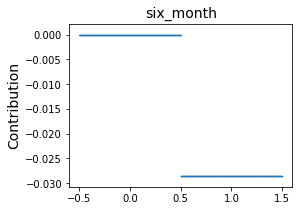

In [14]:
stumps.stump_plots(best_stump_model['features'], best_stump_model['coefs'], indicator="KY")

## RiskSLIM

In [15]:
## load whole data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_stumps.csv")
data = data.sort_values('person_id')
original_data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_data.csv")
original_data = original_data.loc[:,['person_id', 'age_at_current_charge', 'p_charges']]

## load train & test data
train_data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_train_stumps.csv")
test_data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_test_stumps.csv")

In [51]:
best_stump_model = stumps.stump_model(X_train_stumps, 
                                      Y_train_stumps, 
                                      X_test_stumps, 
                                      Y_test_stumps, 
                                      c=0.001, 
                                      columns=cols, 
                                      seed=816)
len(best_stump_model['features'])

13

In [52]:
selected_features = best_stump_model['features']

In [53]:
### Subset features
if 'sex1' in selected_features:
    selected_features = ['general_two_year', 'person_id', 'screening_date', 'race'] + selected_features
    indicator = 1
else:
    selected_features = ['general_two_year', 'person_id', 'screening_date', 'race', 'sex1'] + selected_features
    indicator = 0

sub_data = data[selected_features]
sub_data = pd.merge(sub_data, original_data, on='person_id')
sub_X, sub_Y = sub_data.iloc[:,1:], sub_data.iloc[:,0].values
sub_X.insert(0, '(Intercept)', 1)

In [54]:
riskslim_summary = slim.risk_nested_cv(X=sub_X, 
                                       Y=sub_Y, 
                                       indicator = indicator,
                                       y_label='general_two_year', 
                                       max_coef=5, 
                                       max_coef_number=5, 
                                       max_runtime=1000, 
                                       max_offset=100,
                                       c=1e-6, 
                                       seed=816)

setting c0 = 0.0 to ensure that intercept is not penalized
10/29/19 @ 10:36 PM | 183 rows in lookup table
10/29/19 @ 10:36 PM | ------------------------------------------------------------
10/29/19 @ 10:36 PM | runnning initialization procedure
10/29/19 @ 10:36 PM | ------------------------------------------------------------
10/29/19 @ 10:36 PM | CPA produced 2 cuts
10/29/19 @ 10:36 PM | running naive rounding on 3 solutions
10/29/19 @ 10:36 PM | best objective value: 0.6931
10/29/19 @ 10:36 PM | rounding produced 3 integer solutions
10/29/19 @ 10:36 PM | best objective value is 0.6931
10/29/19 @ 10:36 PM | running sequential rounding on 3 solutions
10/29/19 @ 10:36 PM | best objective value: 0.6931
10/29/19 @ 10:36 PM | sequential rounding produced 0 integer solutions
10/29/19 @ 10:36 PM | polishing 3 solutions
10/29/19 @ 10:36 PM | best objective value: 0.6931
10/29/19 @ 10:36 PM | polishing produced 3 integer solutions
10/29/19 @ 10:36 PM | initialization produced 5 feasible soluti

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
10/29/19 @ 10:36 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5587.
Tried aggregator 1 time.
Reduced MIP has 28 rows, 30 columns, and 81 nonzeros.
Reduced MIP has 13 binaries, 15 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.04 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
10/29/19 @ 10:37 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5585.
Tried aggregator 1 time.
Reduced MIP has 28 rows, 30 columns, and 81 nonzeros.
Reduced MIP has 13 binaries, 15 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.04 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
10/29/19 @ 10:37 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5554.
Tried aggregator 1 time.
Reduced MIP has 28 rows, 30 columns, and 81 nonzeros.
Reduced MIP has 13 binaries, 15 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.04 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
10/29/19 @ 10:37 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5581.
Tried aggregator 1 time.
Reduced MIP has 28 rows, 30 columns, and 81 nonzeros.
Reduced MIP has 13 binaries, 15 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.04 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.02 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
10/29/19 @ 10:37 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5570.
Tried aggregator 1 time.
Reduced MIP has 28 rows, 30 columns, and 81 nonzeros.
Reduced MIP has 13 binaries, 15 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.04 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
10/29/19 @ 10:38 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5575.
Tried aggregator 1 time.
Reduced MIP has 28 rows, 30 columns, and 81 nonzeros.
Reduced MIP has 13 binaries, 15 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.04 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:88: RuntimeWarning:

invalid value encountered in longlong_scalars



setting c0 = 0.0 to ensure that intercept is not penalized
10/29/19 @ 10:38 PM | 183 rows in lookup table
10/29/19 @ 10:38 PM | ------------------------------------------------------------
10/29/19 @ 10:38 PM | runnning initialization procedure
10/29/19 @ 10:38 PM | ------------------------------------------------------------
10/29/19 @ 10:38 PM | CPA produced 2 cuts
10/29/19 @ 10:38 PM | running naive rounding on 4 solutions
10/29/19 @ 10:38 PM | best objective value: 0.6931
10/29/19 @ 10:38 PM | rounding produced 4 integer solutions
10/29/19 @ 10:38 PM | best objective value is 0.6931
10/29/19 @ 10:38 PM | running sequential rounding on 4 solutions
10/29/19 @ 10:38 PM | best objective value: 0.6931
10/29/19 @ 10:38 PM | sequential rounding produced 0 integer solutions
10/29/19 @ 10:38 PM | polishing 4 solutions
10/29/19 @ 10:38 PM | best objective value: 0.6931
10/29/19 @ 10:38 PM | polishing produced 4 integer solutions
10/29/19 @ 10:38 PM | initialization produced 7 feasible soluti

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
10/29/19 @ 10:38 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5574.
Tried aggregator 1 time.
Reduced MIP has 28 rows, 30 columns, and 81 nonzeros.
Reduced MIP has 13 binaries, 15 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.04 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
10/29/19 @ 10:39 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5564.
Tried aggregator 1 time.
Reduced MIP has 28 rows, 30 columns, and 81 nonzeros.
Reduced MIP has 13 binaries, 15 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.04 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
10/29/19 @ 10:39 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5559.
Tried aggregator 1 time.
Reduced MIP has 28 rows, 30 columns, and 81 nonzeros.
Reduced MIP has 13 binaries, 15 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (0.04 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
10/29/19 @ 10:39 PM | adding 250 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5555.
Tried aggregator 1 time.
Reduced MIP has 28 rows, 30 columns, and 81 nonzeros.
Reduced MIP has 13 binaries, 15 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (0.04 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
10/29/19 @ 10:39 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5575.
Tried aggregator 1 time.
Reduced MIP has 28 rows, 30 columns, and 81 nonzeros.
Reduced MIP has 13 binaries, 15 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (0.04 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
10/29/19 @ 10:40 PM | adding 245 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5565.
Tried aggregator 1 time.
Reduced MIP has 28 rows, 30 columns, and 81 nonzeros.
Reduced MIP has 13 binaries, 15 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.04 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:88: RuntimeWarning:

invalid value encountered in longlong_scalars



setting c0 = 0.0 to ensure that intercept is not penalized
10/29/19 @ 10:40 PM | 183 rows in lookup table
10/29/19 @ 10:40 PM | ------------------------------------------------------------
10/29/19 @ 10:40 PM | runnning initialization procedure
10/29/19 @ 10:40 PM | ------------------------------------------------------------
10/29/19 @ 10:40 PM | CPA produced 2 cuts
10/29/19 @ 10:40 PM | running naive rounding on 4 solutions
10/29/19 @ 10:40 PM | best objective value: 0.6931
10/29/19 @ 10:40 PM | rounding produced 4 integer solutions
10/29/19 @ 10:40 PM | best objective value is 0.6931
10/29/19 @ 10:40 PM | running sequential rounding on 4 solutions
10/29/19 @ 10:40 PM | best objective value: 0.6931
10/29/19 @ 10:40 PM | sequential rounding produced 0 integer solutions
10/29/19 @ 10:40 PM | polishing 4 solutions
10/29/19 @ 10:40 PM | best objective value: 0.6931
10/29/19 @ 10:40 PM | polishing produced 4 integer solutions
10/29/19 @ 10:40 PM | initialization produced 7 feasible soluti

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
10/29/19 @ 10:40 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5571.
Tried aggregator 1 time.
Reduced MIP has 28 rows, 30 columns, and 81 nonzeros.
Reduced MIP has 13 binaries, 15 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.04 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
10/29/19 @ 10:40 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5588.
Tried aggregator 1 time.
Reduced MIP has 28 rows, 30 columns, and 81 nonzeros.
Reduced MIP has 13 binaries, 15 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.04 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
10/29/19 @ 10:41 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5573.
Tried aggregator 1 time.
Reduced MIP has 28 rows, 30 columns, and 81 nonzeros.
Reduced MIP has 13 binaries, 15 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.04 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.02 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
10/29/19 @ 10:41 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5600.
Tried aggregator 1 time.
Reduced MIP has 28 rows, 30 columns, and 81 nonzeros.
Reduced MIP has 13 binaries, 15 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.04 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
10/29/19 @ 11:03 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5577.
Tried aggregator 1 time.
Reduced MIP has 28 rows, 30 columns, and 81 nonzeros.
Reduced MIP has 13 binaries, 15 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.04 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
10/29/19 @ 11:03 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5582.
Tried aggregator 1 time.
Reduced MIP has 28 rows, 30 columns, and 81 nonzeros.
Reduced MIP has 13 binaries, 15 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (0.04 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:88: RuntimeWarning:

invalid value encountered in longlong_scalars



setting c0 = 0.0 to ensure that intercept is not penalized
10/29/19 @ 11:04 PM | 183 rows in lookup table
10/29/19 @ 11:04 PM | ------------------------------------------------------------
10/29/19 @ 11:04 PM | runnning initialization procedure
10/29/19 @ 11:04 PM | ------------------------------------------------------------
10/29/19 @ 11:04 PM | CPA produced 2 cuts
10/29/19 @ 11:04 PM | running naive rounding on 4 solutions
10/29/19 @ 11:04 PM | best objective value: 0.6931
10/29/19 @ 11:04 PM | rounding produced 4 integer solutions
10/29/19 @ 11:04 PM | best objective value is 0.6931
10/29/19 @ 11:04 PM | running sequential rounding on 4 solutions
10/29/19 @ 11:04 PM | best objective value: 0.6931
10/29/19 @ 11:04 PM | sequential rounding produced 0 integer solutions
10/29/19 @ 11:04 PM | polishing 4 solutions
10/29/19 @ 11:04 PM | best objective value: 0.6931
10/29/19 @ 11:04 PM | polishing produced 4 integer solutions
10/29/19 @ 11:04 PM | initialization produced 7 feasible soluti

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
10/29/19 @ 11:04 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5580.
Tried aggregator 1 time.
Reduced MIP has 28 rows, 30 columns, and 81 nonzeros.
Reduced MIP has 13 binaries, 15 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.04 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
10/29/19 @ 11:04 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5569.
Tried aggregator 1 time.
Reduced MIP has 28 rows, 30 columns, and 81 nonzeros.
Reduced MIP has 13 binaries, 15 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.04 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
10/29/19 @ 11:04 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5598.
Tried aggregator 1 time.
Reduced MIP has 28 rows, 30 columns, and 81 nonzeros.
Reduced MIP has 13 binaries, 15 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.04 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
10/29/19 @ 11:04 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5592.
Tried aggregator 1 time.
Reduced MIP has 28 rows, 30 columns, and 81 nonzeros.
Reduced MIP has 13 binaries, 15 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.04 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
10/29/19 @ 11:05 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5591.
Tried aggregator 1 time.
Reduced MIP has 28 rows, 30 columns, and 81 nonzeros.
Reduced MIP has 13 binaries, 15 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.04 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.02 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
10/29/19 @ 11:05 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5586.
Tried aggregator 1 time.
Reduced MIP has 28 rows, 30 columns, and 81 nonzeros.
Reduced MIP has 13 binaries, 15 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (0.04 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:88: RuntimeWarning:

invalid value encountered in longlong_scalars



setting c0 = 0.0 to ensure that intercept is not penalized
10/29/19 @ 11:05 PM | 183 rows in lookup table
10/29/19 @ 11:05 PM | ------------------------------------------------------------
10/29/19 @ 11:05 PM | runnning initialization procedure
10/29/19 @ 11:05 PM | ------------------------------------------------------------
10/29/19 @ 11:05 PM | CPA produced 2 cuts
10/29/19 @ 11:05 PM | running naive rounding on 4 solutions
10/29/19 @ 11:05 PM | best objective value: 0.6931
10/29/19 @ 11:05 PM | rounding produced 4 integer solutions
10/29/19 @ 11:05 PM | best objective value is 0.6931
10/29/19 @ 11:05 PM | running sequential rounding on 4 solutions
10/29/19 @ 11:05 PM | best objective value: 0.6931
10/29/19 @ 11:05 PM | sequential rounding produced 0 integer solutions
10/29/19 @ 11:05 PM | polishing 4 solutions
10/29/19 @ 11:05 PM | best objective value: 0.6931
10/29/19 @ 11:05 PM | polishing produced 4 integer solutions
10/29/19 @ 11:05 PM | initialization produced 7 feasible soluti

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
10/29/19 @ 11:05 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5557.
Tried aggregator 1 time.
Reduced MIP has 28 rows, 30 columns, and 81 nonzeros.
Reduced MIP has 13 binaries, 15 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.04 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
10/29/19 @ 11:06 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5568.
Tried aggregator 1 time.
Reduced MIP has 28 rows, 30 columns, and 81 nonzeros.
Reduced MIP has 13 binaries, 15 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.04 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
10/29/19 @ 11:06 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5555.
Tried aggregator 1 time.
Reduced MIP has 28 rows, 30 columns, and 81 nonzeros.
Reduced MIP has 13 binaries, 15 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.04 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
10/29/19 @ 11:06 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5587.
Tried aggregator 1 time.
Reduced MIP has 28 rows, 30 columns, and 81 nonzeros.
Reduced MIP has 13 binaries, 15 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.04 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
10/29/19 @ 11:06 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5572.
Tried aggregator 1 time.
Reduced MIP has 28 rows, 30 columns, and 81 nonzeros.
Reduced MIP has 13 binaries, 15 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.04 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
10/29/19 @ 11:06 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5568.
Tried aggregator 1 time.
Reduced MIP has 28 rows, 30 columns, and 81 nonzeros.
Reduced MIP has 13 binaries, 15 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.04 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test2\utils\fairness_functions.py:88: RuntimeWarning:

invalid value encountered in longlong_scalars



In [55]:
np.mean(riskslim_summary['train_auc']), np.mean(riskslim_summary['test_auc'])

(0.7077852072338248, 0.7077866238930165)

### Single RiskSLIM Model

In [56]:
selected_features = ['general_two_year'] + best_stump_model['features']
sub_train_data = train_data[selected_features]
sub_test_data = test_data[selected_features]

## split x 
sub_train_X = sub_train_data.iloc[:,1:]
sub_train_X.insert(0, '(Intercept)', 1)
cols = sub_train_X.columns.tolist()
sub_train_X = sub_train_X.values
sub_test_X = sub_test_data.iloc[:,1:].values

## split y
sub_train_Y = sub_train_data.iloc[:,0].values.reshape(-1,1)
sub_test_Y = sub_test_data.iloc[:,0].values.reshape(-1,1)

## sample weight
sample_weights = np.repeat(1, len(sub_train_Y))

In [57]:
new_train_data = {
    'X': sub_train_X,
    'Y': sub_train_Y,
    'variable_names': cols,
    'outcome_name': 'general_two_year',
    'sample_weights': sample_weights
}

In [58]:
model_info, mip_info, lcpa_info = slim.risk_slim(new_train_data, 
                                                 max_coefficient=5, 
                                                 max_L0_value=5, 
                                                 c0_value=1e-6, 
                                                 max_offset=100, 
                                                 max_runtime=1000)
print_model(model_info['solution'], new_train_data)

setting c0 = 0.0 to ensure that intercept is not penalized
10/29/19 @ 11:09 PM | 183 rows in lookup table
10/29/19 @ 11:09 PM | ------------------------------------------------------------
10/29/19 @ 11:09 PM | runnning initialization procedure
10/29/19 @ 11:09 PM | ------------------------------------------------------------
10/29/19 @ 11:09 PM | CPA produced 2 cuts
10/29/19 @ 11:09 PM | running naive rounding on 4 solutions
10/29/19 @ 11:09 PM | best objective value: 0.6931
10/29/19 @ 11:09 PM | rounding produced 4 integer solutions
10/29/19 @ 11:09 PM | best objective value is 0.6931
10/29/19 @ 11:09 PM | running sequential rounding on 4 solutions
10/29/19 @ 11:09 PM | best objective value: 0.6931
10/29/19 @ 11:09 PM | sequential rounding produced 0 integer solutions
10/29/19 @ 11:09 PM | polishing 4 solutions
10/29/19 @ 11:09 PM | best objective value: 0.6931
10/29/19 @ 11:09 PM | polishing produced 4 integer solutions
10/29/19 @ 11:09 PM | initialization produced 7 feasible soluti

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
10/29/19 @ 11:09 PM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5578.
Tried aggregator 1 time.
Reduced MIP has 28 rows, 30 columns, and 81 nonzeros.
Reduced MIP has 13 binaries, 15 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.04 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

In [59]:
sub_train_X = sub_train_X[:,1:]
sub_train_Y[sub_train_Y == -1] = 0
sub_test_Y[sub_test_Y == -1] = 0

In [60]:
roc_auc_score(sub_train_Y, slim.riskslim_prediction(sub_train_X, np.array(cols), model_info).reshape(-1,1))

0.7065871438620888

In [61]:
roc_auc_score(sub_test_Y, slim.riskslim_prediction(sub_test_X, np.array(cols), model_info).reshape(-1,1))

0.7183848239686512

### Arnold PSA

In [72]:
### load data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_data.csv").sort_values('person_id')
settings = load_settings()
for decoder_name, decoder_dict in settings['decoders'].items():
    data = data.replace({decoder_name: decoder_dict})  
    
# compute scaled arnold scores
for score in ['arnold_nca' , 'arnold_nvca', 'arnold_fta']:
    data[score] = data[score + "_raw"]
    data = data.replace({score: settings[score + '_scaler'] })
    if score != 'arnold_nvca':
        data[score] = data[score].astype(int)
X_arnold = data.loc[:,['arnold_nca', 'sex', 'race', 'person_id', 'screening_date', 'age_at_current_charge', 'p_charges']]
Y_arnold = data['general_two_year'].values

In [73]:
## set up cross validation
cv = KFold(n_splits=5,shuffle=True,random_state=816)
arnold_auc = []
race_auc = []
condition_pn = []
no_condition_pn = []

i = 0
for train, test in cv.split(X_arnold, Y_arnold):
    
    train_x, train_y = X_arnold.iloc[train], Y_arnold[train]
    test_x, test_y = X_arnold.iloc[test], Y_arnold[test]
    holdout_with_attrs = test_x.copy()
    
    ################################
    ## arnold_auc
    arnold_auc.append(roc_auc_score(test_y, test_x['arnold_nca'].values))
    
    ################################
    ## race_auc
    arnold_race_auc = fairness.fairness_in_auc(df = holdout_with_attrs,
                                               probs = test_x['arnold_nca'],
                                               labels = test_y)
    arnold_race_auc_final = arnold_race_auc.assign(fold_num = [i]*arnold_race_auc['Attribute'].count())
    race_auc.append(arnold_race_auc_final)
    
    ################################
    ## condition pn
    arnold_condition_pn = fairness.conditional_balance_positive_negative(df = holdout_with_attrs,
                                                                         probs = test_x['arnold_nca'],
                                                                         labels = test_y)
    arnold_condition_pn_final = arnold_condition_pn.assign(fold_num = [i]*arnold_condition_pn['Attribute'].count())
    condition_pn.append(arnold_condition_pn_final)
    
    ################################
    ## no condition pn
    arnold_no_condition_pn = fairness.balance_positive_negative(df = holdout_with_attrs,
                                                                probs = test_x['arnold_nca'],
                                                                labels = test_y)
    arnold_no_condition_pn_final = arnold_no_condition_pn.assign(fold_num = [i]*arnold_no_condition_pn['Attribute'].count())
    no_condition_pn.append(arnold_no_condition_pn_final)
    
    i += 1
    
## race_auc
arnold_race_auc = pd.concat(race_auc, ignore_index=True)
arnold_race_auc.sort_values(["fold_num", "Attribute"], inplace=True)
arnold_race_auc = arnold_race_auc.reset_index(drop=True)

## condition_pn
arnold_condition_pn = pd.concat(condition_pn, ignore_index=True)
arnold_condition_pn.sort_values(["fold_num", "Attribute"], inplace=True)
arnold_condition_pn = arnold_condition_pn.reset_index(drop=True)

## no_condition_pn
arnold_no_condition_pn = pd.concat(no_condition_pn, ignore_index=True)
arnold_no_condition_pn.sort_values(["fold_num", "Attribute"], inplace=True)
arnold_no_condition_pn = arnold_no_condition_pn.reset_index(drop=True)

### Results

In [74]:
#### save results
summary_general2_KY_interpret = {"CART": cart_summary,
                                 "EBM": ebm_summary, 
                                 'Lasso Stumps': stump_summary, 
                                 'RiskSLIM': riskslim_summary, 
                                 'Arnold PSA': arnold_auc}
%store summary_general2_KY_interpret

Stored 'summary_general2_KY_interpret' (dict)


In [75]:
results = [["CART", np.mean(cart_summary['holdout_test_auc']), np.mean(cart_summary['auc_diffs'])],
           ["EBM", np.mean(ebm_summary['holdout_test_auc']), np.mean(ebm_summary['auc_diffs'])], 
           ["Lasso Stumps", np.mean(stump_summary['holdout_test_auc']), np.mean(stump_summary['auc_diffs'])],
           ['RiskSLIM', np.mean(riskslim_summary['test_auc']), np.std(riskslim_summary['test_auc'])],
           ['Arnold PSA', round(np.mean(arnold_auc), 3)]]
results

[['CART', 0.7358934454634021, 0.008078291803447147],
 ['EBM', 0.7419332228253251, 0.002924320379080059],
 ['Lasso Stumps', 0.7399658211823634, 0.0003093138235448878],
 ['RiskSLIM', 0.7077866238930165, 0.0017397650852464244],
 ['Arnold PSA', 0.686]]

In [76]:
auc = [np.mean(cart_summary['holdout_test_auc']), 
       np.mean(ebm_summary['holdout_test_auc']), 
       np.mean(stump_summary['holdout_test_auc']), 
       np.mean(riskslim_summary['test_auc'])]

In [77]:
path = "C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY Results/Models/Two Year/"
results = [["", "CART", "EBM", "Lasso Stumps", "RiskSLIM", "Performance Range", "Arnold PSA"],
           ["General", np.str((round(np.mean(cart_summary['holdout_test_auc']), 3))) + " (" + np.str(round(np.std(cart_summary['holdout_test_auc']), 3)) + ")", 
            np.str(round(np.mean(ebm_summary['holdout_test_auc']),3)) + " (" + np.str(round(np.std(ebm_summary['holdout_test_auc']), 3)) + ")", 
            np.str(round(np.mean(stump_summary['holdout_test_auc']),3)) + " (" + np.str(round(np.std(stump_summary['holdout_test_auc']), 3)) + ")",             
            np.str(round(np.mean(riskslim_summary['test_auc']),3)) + " (" + np.str(round(np.std(riskslim_summary['test_auc']), 3)) + ")", 
            round(np.max(auc) - np.min(auc), 3),
            np.str(round(np.mean(arnold_auc), 3)) + " (" + np.str(round(np.std(arnold_auc),3)) + ")"]]
with open(path + 'Interpretable Models Summary.csv', 'w') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(results)

### confusion matrix

In [78]:
cart_confusion = cart_summary['confusion_matrix_stats']
ebm_confusion = ebm_summary['confusion_matrix_stats']
riskslim_confusion = riskslim_summary['confusion_matrix_stats']
stumps_confusion = stump_summary['confusion_matrix_stats']

cart_confusion.to_csv(r'C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/confusion/two-year/general/cart_confusion.csv', index=None,header=True)
ebm_confusion.to_csv(r'C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/confusion/two-year/general/ebm_confusion.csv', index=None,header=True)
riskslim_confusion.to_csv(r'C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/confusion/two-year/general/riskslim_confusion.csv', index=None,header=True)
stumps_confusion.to_csv(r'C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/confusion/two-year/general/stumps_confusion.csv', index=None,header=True)

### calibration matrix

In [79]:
cart_calibration = cart_summary['calibration_stats']
ebm_calibration = ebm_summary['calibration_stats']
riskslim_calibration = riskslim_summary['calibration_stats']
stumps_calibration = stump_summary['calibration_stats']

cart_calibration.to_csv(r'C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/calibration/two-year/general/cart_calibration.csv', index=None,header=True)
ebm_calibration.to_csv(r'C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/calibration/two-year/general/ebm_calibration.csv', index=None,header=True)
riskslim_calibration.to_csv(r'C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/calibration/two-year/general/riskslim_calibration.csv', index=None,header=True)
stumps_calibration.to_csv(r'C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/calibration/two-year/general/stumps_calibration.csv', index=None,header=True)

### race auc matrix

In [80]:
cart_race_auc = cart_summary['race_auc']
ebm_race_auc = ebm_summary['race_auc']
riskslim_race_auc = riskslim_summary['race_auc']
stumps_race_auc = stump_summary['race_auc']

cart_race_auc.to_csv(r'C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/race-auc/two-year/general/cart_race_auc.csv', index=None,header=True)
ebm_race_auc.to_csv(r'C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/race-auc/two-year/general/ebm_race_auc.csv', index=None,header=True)
riskslim_race_auc.to_csv(r'C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/race-auc/two-year/general/riskslim_race_auc.csv', index=None,header=True)
stumps_race_auc.to_csv(r'C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/race-auc/two-year/general/stumps_race_auc.csv', index=None,header=True)
arnold_race_auc.to_csv(r'C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/race-auc/two-year/general/arnold_race_auc.csv', index=None,header=True)

### condition pn

In [81]:
cart_condition_pn = cart_summary['condition_pn']
ebm_condition_pn = ebm_summary['condition_pn']
riskslim_condition_pn = riskslim_summary['condition_pn']
stumps_condition_pn = stump_summary['condition_pn']

cart_condition_pn.to_csv(r'C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/condition-pn/two-year/general/cart_condition_pn.csv', index=None,header=True)
ebm_condition_pn.to_csv(r'C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/condition-pn/two-year/general/ebm_condition_pn.csv', index=None,header=True)
riskslim_condition_pn.to_csv(r'C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/condition-pn/two-year/general/riskslim_condition_pn.csv', index=None,header=True)
stumps_condition_pn.to_csv(r'C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/condition-pn/two-year/general/stumps_condition_pn.csv', index=None,header=True)
arnold_condition_pn.to_csv(r'C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/condition-pn/two-year/general/arnold_conditon_pn.csv', index=None,header=True)

### no condition pn

In [82]:
cart_no_condition_pn = cart_summary['no_condition_pn']
ebm_no_condition_pn = ebm_summary['no_condition_pn']
riskslim_no_condition_pn = riskslim_summary['no_condition_pn']
stumps_no_condition_pn = stump_summary['no_condition_pn']

cart_no_condition_pn.to_csv(r'C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/no-condition-pn/two-year/general/cart_no_condition_pn.csv', index=None,header=True)
ebm_no_condition_pn.to_csv(r'C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/no-condition-pn/two-year/general/ebm_no_condition_pn.csv', index=None,header=True)
riskslim_no_condition_pn.to_csv(r'C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/no-condition-pn/two-year/general/riskslim_no_condition_pn.csv', index=None,header=True)
stumps_no_condition_pn.to_csv(r'C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/no-condition-pn/two-year/general/stumps_no_condition_pn.csv', index=None,header=True)
arnold_no_condition_pn.to_csv(r'C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/no-condition-pn/two-year/general/arnold_no_conditon_pn.csv', index=None,header=True)